In [120]:
import matplotlib.pyplot as plt

In [121]:
import numpy as np

In [122]:
import os

In [123]:
import PIL

In [124]:
import tensorflow as tf

In [125]:
from tensorflow import keras

In [126]:
from tensorflow.keras import layers

In [127]:
from tensorflow.keras.models import Sequential

In [128]:
import pathlib

In [20]:
dataset_url = "http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar"

In [21]:
data_dir = tf.keras.utils.get_file('Images', origin=dataset_url, untar=True)

793583616/793579520 [==============================] - 119s 0us/step


In [22]:
data_dir = pathlib.Path(data_dir)

In [23]:
image_count = len(list(data_dir.glob('*/*.jpg')))

In [24]:
print(image_count)

20580


In [26]:
chihuahua = list(data_dir.glob('n02085620-Chihuahua/*'))

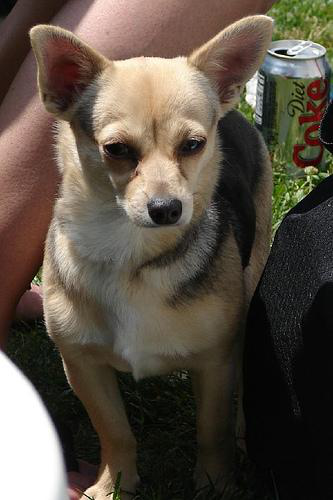

In [27]:
PIL.Image.open(str(chihuahua[0]))

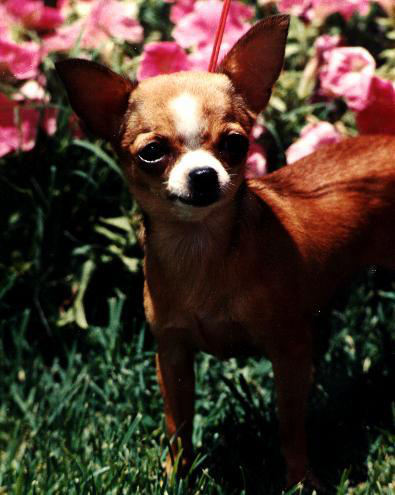

In [28]:
PIL.Image.open(str(chihuahua[1]))

In [29]:
japanese_spaniel = list(data_dir.glob('n02085782-Japanese_spaniel/*'))

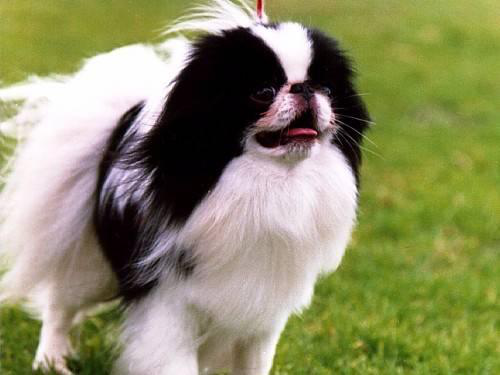

In [30]:
PIL.Image.open(str(japanese_spaniel[0]))

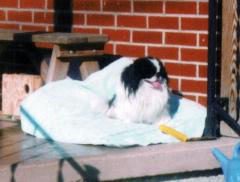

In [31]:
PIL.Image.open(str(japanese_spaniel[1]))

In [140]:
batch_size = 32

In [141]:
img_height = 180

In [142]:
img_width = 180

In [35]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 20580 files belonging to 120 classes.
Using 16464 files for training.


In [36]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 20580 files belonging to 120 classes.
Using 4116 files for validation.


In [37]:
class_names = train_ds.class_names

In [38]:
print(class_names)

['n02085620-Chihuahua', 'n02085782-Japanese_spaniel', 'n02085936-Maltese_dog', 'n02086079-Pekinese', 'n02086240-Shih-Tzu', 'n02086646-Blenheim_spaniel', 'n02086910-papillon', 'n02087046-toy_terrier', 'n02087394-Rhodesian_ridgeback', 'n02088094-Afghan_hound', 'n02088238-basset', 'n02088364-beagle', 'n02088466-bloodhound', 'n02088632-bluetick', 'n02089078-black-and-tan_coonhound', 'n02089867-Walker_hound', 'n02089973-English_foxhound', 'n02090379-redbone', 'n02090622-borzoi', 'n02090721-Irish_wolfhound', 'n02091032-Italian_greyhound', 'n02091134-whippet', 'n02091244-Ibizan_hound', 'n02091467-Norwegian_elkhound', 'n02091635-otterhound', 'n02091831-Saluki', 'n02092002-Scottish_deerhound', 'n02092339-Weimaraner', 'n02093256-Staffordshire_bullterrier', 'n02093428-American_Staffordshire_terrier', 'n02093647-Bedlington_terrier', 'n02093754-Border_terrier', 'n02093859-Kerry_blue_terrier', 'n02093991-Irish_terrier', 'n02094114-Norfolk_terrier', 'n02094258-Norwich_terrier', 'n02094433-Yorkshire_t

In [39]:
import matplotlib.pyplot as plt

In [40]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [41]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [42]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [43]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

In [44]:
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [45]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [46]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

In [47]:
image_batch, labels_batch = next(iter(normalized_ds))

In [48]:
first_image = image_batch[0]

In [49]:
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [50]:
num_classes = 120

In [51]:
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [52]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [53]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

In [56]:
epochs=10

In [57]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

515/515 [==============================] - 1633s 3s/step - loss: 4.3691 - accuracy: 0.0524 - val_loss: 4.4000 - val_accuracy: 0.0469


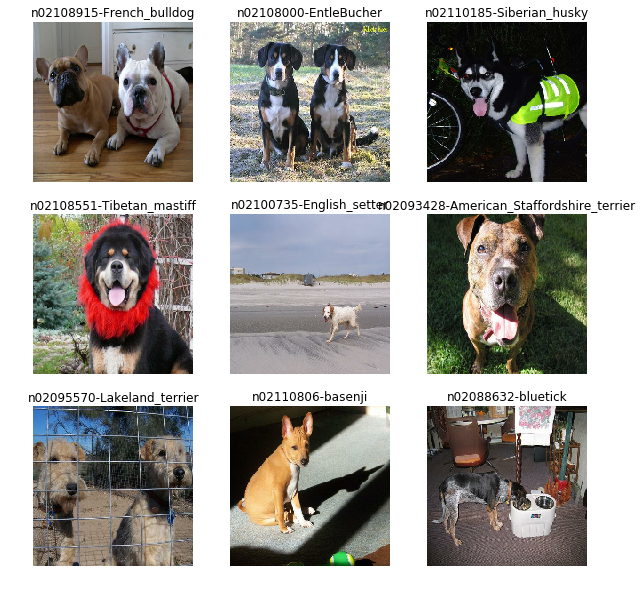

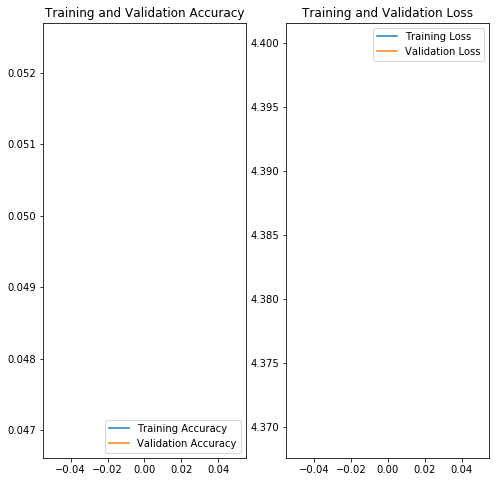

In [58]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [59]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

In [60]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [61]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [62]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [63]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)       

In [64]:
epochs = 10

In [65]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

515/515 [==============================] - 1832s 4s/step - loss: 4.6886 - accuracy: 0.0197 - val_loss: 4.4680 - val_accuracy: 0.0369


In [66]:
acc = history.history['accuracy']

In [67]:
val_acc = history.history['val_accuracy']

In [68]:
loss = history.history['loss']

In [69]:
val_loss = history.history['val_loss']

In [70]:
epochs_range = range(epochs)

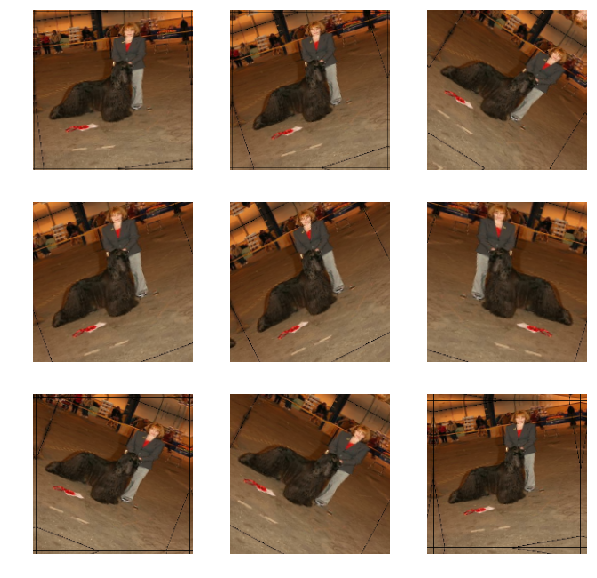

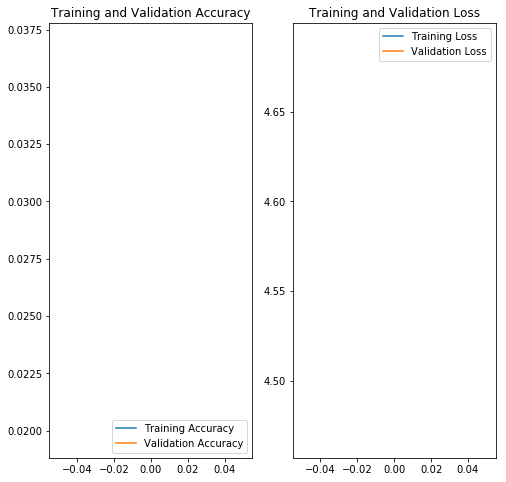

In [71]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [177]:
sunflower_url = "https://img.olx.com.br/images/74/747006947286706.jpg"
sunflower_path = tf.keras.utils.get_file('Cao3', origin=sunflower_url)

   8192/Unknown - 0s 0us/step

In [178]:
img = keras.preprocessing.image.load_img(
    sunflower_path, target_size=(img_height, img_width)
)

In [179]:
img_array = keras.preprocessing.image.img_to_array(img)

In [180]:
img_array = tf.expand_dims(img_array, 0) # Create a batch

In [181]:
predictions = model.predict(img_array)

In [182]:
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to n02101388-Brittany_spaniel with a 1.66 percent confidence.
